# Imports and installs

In [1]:
#pip install XGBoost

In [111]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import r2_score, accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
import shap
import itertools
import math

In [112]:
import warnings
warnings.filterwarnings('ignore')

# Loading the Dataframe

## Merging the Seasons csv files (2019-2020 untill 2021-2022)

In [113]:
def get_data(league1, wall=False):
    '''
    This function is getting the CSVs in the raw_data folder per country.
    We can have only one country, we just need to pass the name of the country in lower case.
    Or we can have all the countries inside the folder, we just need to pass the param wall=True.
    '''
    data = pd.DataFrame()
    if wall:
        leagues = listdir(f'../complete/')
        data = pd.DataFrame()
        for league in leagues:
            files = listdir(f'../complete/{league}')
            for file in files:
                df = pd.read_csv((f'../complete/{league}/'+file), encoding='windows-1254')
                df['country']=str(file)[0:2]
                data = pd.concat([data, df])
        return data
    else:
        files = [file for file in listdir(f'../complete/{league1}')]
        for file in files:
            df = pd.read_csv(f'../complete/{league1}/'+file)
            df['country']=str(file)[0:2]
            data = pd.concat([data, df])
        return data

In [114]:
data = get_data('italy', wall=True)

In [115]:
data['Avg2<2.5'] = data['BbAv<2.5'].fillna(0) + data['Avg<2.5'].fillna(0) 

In [116]:
data['Avg2>2.5'] = data['BbAv>2.5'].fillna(0) + data['Avg>2.5'].fillna(0) 

In [117]:
data['Max2<2.5'] = data['BbMx<2.5'].fillna(0) + data['Max<2.5'].fillna(0) 

In [118]:
data['Max2>2.5'] = data['BbMx>2.5'].fillna(0) + data['Max>2.5'].fillna(0) 

In [119]:
data = data[data['Avg2<2.5']>1]

# Features Engineering

In [120]:
#Loading the function

def feature_engineering(data, b=20, binned=False):
    '''
    This function creates all the columns that will be needed to create the analysis 
    and return the dataframe with all this changes
    
    b is the number of bins that we want to work with. Our start value for b will be 20.
        '''
    #------------------------Number of Goals, Over and Under -----------------------------------
    
    # total number of goals = goals from the home team + goals from visiting team
    data['nb_goals']=data['FTHG']+data['FTAG']

    # boolean: true or false regarding whether they were more than 2.5 goals
    data['over_2.5_goals']=data['nb_goals']>2.5

    # boolean: true or false regarding whether they were less than 2.5 goals
    data['under_2.5_goals']=data['nb_goals']<2.5
    
    #-----------------------------Payout Opening ----------------------------------------------
    
    # payout under 2.5 for Average OPENING odds
    data['payout_avg_under_2.5'] = data['under_2.5_goals']*data['Avg2<2.5']

    # payout over 2.5 for Average OPENING odds
    data['payout_avg_over_2.5'] = data['over_2.5_goals']*data['Avg2>2.5']

    #payout UNDER 2.5 for PINACLE specifically
    data['payout_under_2.5_pinacle'] = data['under_2.5_goals']*data['P<2.5']

    #payout OVER 2.5 for PINACLE specifically
    data['payout_over_2.5_pinacle'] = data['over_2.5_goals']*data['P>2.5']

    #payout UNDER 2.5 for 365 specifically
    data['payout_under_2.5_365'] = data['under_2.5_goals']*data['B365<2.5']

    #payout OVER 2.5 for 365 specifically
    data['payout_over_2.5_365'] = data['over_2.5_goals']*data['B365>2.5']
    
    #------------------------------Payout Closing --------------------------------------------
    
    # payout under 2.5 for Average CLOSING odds
    data['payout_avg_under_closing_2.5'] = data['under_2.5_goals']*data['AvgC<2.5']

    # payout over 2.5 for Average CLOSING odds
    data['payout_avg_over_closing_2.5'] = data['over_2.5_goals']*data['AvgC>2.5']

    #payout UNDER 2.5 for PINACLE closing ddds specifically
    data['payout_under_2.5_pinacle_closing'] = data['under_2.5_goals']*data['PC<2.5']

    #payout OVER 2.5 for PINACLE closing odds specifically
    data['payout_over_2.5_pinacle_closing'] = data['over_2.5_goals']*data['PC>2.5']

    #payout UNDER 2.5 for 365 closing odds specifically
    data['payout_under_2.5_365_closing'] = data['under_2.5_goals']*data['B365C<2.5']

    #payout OVER 2.5 for 365 closing odds specifically
    data['payout_over_2.5_365_closing'] = data['over_2.5_goals']*data['B365C>2.5']
    
    #-------------------------- Implied Probability Opening ----------------------------------------
    
    #Implied Probability UNDER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability <2.5 avg']=1/data['Avg<2.5']*100

    #Implied Probability OVER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability >2.5 avg']=1/data['Avg>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE
    data['Implied Probability <2.5 pinacle']=1/data['P<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE
    data['Implied Probability >2.5 pinacle']=1/data['P>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365
    data['Implied Probability <2.5 365']=1/data['B365<2.5']*100

    #Implied Probability OVER 2.5 goals for 365
    data['Implied Probability >2.5 365']=1/data['B365>2.5']*100
    
    #------------------------- Implied Probability Closing -----------------------------------
    
    #Implied Probability UNDER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability <2.5 avg closing']=1/data['AvgC<2.5']*100

    #Implied Probability OVER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability >2.5 avg closing']=1/data['AvgC>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE closing odds
    data['Implied Probability <2.5 pinacle closing']=1/data['PC<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE closing odds
    data['Implied Probability >2.5 pinacle closing']=1/data['PC>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365 closing odds
    data['Implied Probability <2.5 365 closing']=1/data['B365C<2.5']*100

    #Implied Probability OVER 2.5 goals for 365 closing odds
    data['Implied Probability >2.5 365 closing']=1/data['B365C>2.5']*100
    
    #---------------------------- Binning IP Opening -------------------------------------

    b=b
    bins = np.arange(0, 101, int(100/b))
    bins = bins.tolist()

    #Binning UNDER 2.5 Average Market opening odds
    data['binned <2.5 avg'] = pd.cut(data['Implied Probability <2.5 avg'], bins)

    #Binning Over 2.5 Average Market opening odds
    data['binned >2.5 avg'] = pd.cut(data['Implied Probability >2.5 avg'], bins)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned <2.5 pinacle'] = pd.cut(data['Implied Probability <2.5 pinacle'], bins)

    #Binned OVER 2.5 Pinnacle
    data['binned >2.5 pinacle'] = pd.cut(data['Implied Probability >2.5 pinacle'], bins)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned <2.5 365'] = pd.cut(data['Implied Probability <2.5 365'], bins)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned >2.5 365'] = pd.cut(data['Implied Probability >2.5 365'], bins)
    
    #----------------------------- Binning IP Closing ------------------------------------------------

    #Binning UNDER 2.5 Average Market closing odds
    data['binned <2.5 avg closing'] = pd.cut(data['Implied Probability <2.5 avg closing'], bins)

    #Binning OVER 2.5 Average Market closing odds
    data['binned >2.5 avg closing'] = pd.cut(data['Implied Probability >2.5 avg closing'], bins)

    #Binned UNDER 2.5 Pinnacle closing odds
    data['binned <2.5 pinacle closing'] = pd.cut(data['Implied Probability <2.5 pinacle closing'], bins)

    #Binned OVER 2.5 Pinnacle CLOSING odds
    data['binned >2.5 pinacle closing'] = pd.cut(data['Implied Probability >2.5 pinacle closing'], bins)

    #Binned UNDER 2.5 bet365 CLOSING odds
    data['binned <2.5 365 closing'] = pd.cut(data['Implied Probability <2.5 365 closing'], bins)

    #Binned OVER 2.5 bet365 CLOSING odds
    data['binned >2.5 365 closing'] = pd.cut(data['Implied Probability >2.5 365 closing'], bins)
    
    #---------------------------- Binning Odds Opening ----------------------------------------------------
    
    bins2 = [1, 1.5, 2, 3, 100]

    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg'] = pd.cut(data['Avg<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg'] = pd.cut(data['Avg>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle'] = pd.cut(data['P<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle'] = pd.cut(data['P>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365'] = pd.cut(data['B365<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365'] = pd.cut(data['B365>2.5'], bins2)
    
    #----------------------------- Binning Odds Closing ----------------------------------------------------------
    
    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg'] = pd.cut(data['Avg2<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg'] = pd.cut(data['Avg2>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle closing'] = pd.cut(data['PC<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle closing'] = pd.cut(data['PC>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365 closing'] = pd.cut(data['B365C<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365 closing'] = pd.cut(data['B365C>2.5'], bins2)
    
    
    #----------------------------- Other Features from D3 ------------------------------------------------------
    
    data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
    data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
    data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
    data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
    data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
    data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
    
    #----------------------- Odds and probability of the home team scoring under 2.5 -------------------------------
    
#     lst1 = []
#     lst2 = []
#     for i, team in enumerate(data['HomeTeam']):
#         date = data['Date'].iloc[i]
#         total = len(data[(data['HomeTeam'] == team) & (data['Date'] < date)])
#         n_under_home = data[(data['HomeTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
#         try:
#             lst1.append(1/(n_under_home[1]/total))
#             lst2.append(n_under_home[1]/total)
#         except:
#             lst1.append(np.nan)
#             lst2.append(np.nan)

#     data['odds_home_under'] = lst1
#     data['prob_home_under'] = lst2
    
#     #binning the probability of the home team to have a game of less than 2.5 score
#     data['binned prob_home_under'] = pd.cut(data['prob_home_under']*100, bins)
    
    
    #----------------------- Odds and probability of the away team scoring under 2.5 -------------------------------
    
#     lst3 = []
#     lst4  = []
#     for i, team in enumerate(data['AwayTeam']):
#         date = data['Date'].iloc[i]
#         total2 = len(data[(data['AwayTeam'] == team) & (data['Date'] < date)])
#         n_under_away2 = data[(data['AwayTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
#         try:
#             lst3.append(1/(n_under_away2[1] / total2))
#             lst4.append(n_under_away2[1] / total2)
#         except:
#             lst3.append(np.nan)
#             lst4.append(np.nan)

#     data['odds_away_under'] = lst3
#     data['prob_away_under'] = lst4
    
#     #binning the probability of the away team to have a game of less than 2.5 score
#     data['binned prob_away_under'] = pd.cut(data['prob_away_under']*100, bins)

    #-------------------------- Creating the prob and odds of the game -----------------------------------------------
#     '''the mean between the probability of the home team to have a score of under 2.5 and the probability 
#     of the away team to do the same'''
    
#     data['odds_game'] = (data['odds_away_under'] +  data['odds_home_under']) / 2
#     data['prob_game'] = (data['prob_away_under'] + data['prob_home_under']) / 2
    
    #-------------------------- OneHotEncoding the binned probabilities columns ------------------------------------------
    

#     if b == 5:
#         data = data[~data['binned prob_home_under'].isna()]
#         ohe = OneHotEncoder(sparse=False)
#         ohe.fit(data[['binned prob_home_under']])
#         bins_encoded = ohe.transform(data[['binned prob_home_under']])
#         data["0, 20"], data["20, 40"], data["40, 60"], data["60, 80"], data["80, 100"] = bins_encoded.T
        
#     if b == 10:
#         data = data[~data['binned prob_home_under'].isna()]
#         ohe = OneHotEncoder(sparse=False)
#         ohe.fit(data[['binned prob_home_under']])
#         bins_encoded = ohe.transform(data[['binned prob_home_under']])
#         data["0, 10"], data["10, 20"], data["20, 30"], data["30, 40"], data["40, 50"], data["50, 60"], \
#         data["60, 70"], data["70, 80"], data["80, 90"], data["90, 100"] = bins_encoded.T
        
#     if b == 20:
#         data = data[~data['binned prob_home_under'].isna()]
#         ohe = OneHotEncoder(sparse=False)
#         ohe.fit(data[['binned prob_home_under']])
#         bins_encoded = ohe.transform(data[['binned prob_home_under']])
#         data["0, 5"], data["5, 10"], data["10, 15"], data["15, 20"], data["20, 25"], data["25, 30"], \
#         data["30, 35"], data["35, 40"], data["40, 45"], data["45, 50"], data["50, 55"], data["55, 60"], \
#         data["60, 65"], data["65, 70"], data["70, 75"], data["75, 80"], data["80, 85"], data["85, 90"], \
#         data["90, 95"], data["95, 100"]= bins_encoded.T
    
    #------------------------------------ Cleaning the data ---------------------------------------------------------
    
    #data = data.dropna(subset=['HomeTeam', 'AwayTeam'], how='any')
    data = data[~data['HomeTeam'].isna()]
    data = data[~data['AwayTeam'].isna()]
    #data = data[~data['PC>2.5'].isna()]
    data = data[~data['Avg2<2.5'].isna()]
    data.drop(columns=['Referee','Unnamed: 105'], inplace=True) #, 'Unnamed: 105' 'Referee', 
    #data.dropna()
    
     #-------------------------- OneHotEncoding the binned odds ------------------------------------------
   
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['binned odds <2.5 avg']])
    bins_encoded = ohe.transform(data[['binned odds <2.5 avg']])
    data["1.0_to_1.5"], data["1.5_to_2.0"], data["2.0_to_3"], data["3_to_100"] = bins_encoded.T
    data.drop(columns='binned odds <2.5 avg', inplace=True)
    
    #-------------------------- OneHotEncoding the binned countries ------------------------------------------

    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country']])
    bins_encoded = ohe.transform(data[['country']])
    data["country_1"], data["country_2"], data["country_3"], data["country_4"], data["country_5"],data["country_6"], data["country_7"], data["country_8"], data["country_9"], data["country_10"], data["country_11"] = bins_encoded.T
    data.drop(columns='country', inplace=True)

    #-------------------------- OneHotEncoding the binned country divisions ------------------------------------------
    
    data['country_division'] = data['Div'].map({'F1':1, 'D1':1, 'I2':2, 'E1':2, 'E2':3, 'F2':2, 'N1':1, 'T1':1, \
                                                'SC2':2, 'SP2':2, 'E0':1,'D2':2, 'G1':1, 'I1':1, 'SC1':2, 'SP1':1,\
                                                'SC0':1, 'SC3':4, 'E3':4, 'P1':1, 'B1':1})
    
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country_division']])
    bins_encoded = ohe.transform(data[['country_division']])
    data["country_div_1"], data["country_div_2"], data["country_div_3"], data["country_div_4"] = bins_encoded.T
    #data.drop(columns='country_division', inplace=True)
    
    return data

In [121]:
#Running the function and creating the dataset data

data = feature_engineering(data, b=5)

In [122]:
b=10
bins = np.arange(0, 101, int(100/b))
bins = bins.tolist()

In [123]:
#   #----------------------- Odds and probability of the home team scoring under 2.5 -------------------------------
    
# lst1 = []
# lst2 = []
# for i, team in enumerate(data['HomeTeam']):
#     date = data['Date'].iloc[i]
#     total = len(data[(data['HomeTeam'] == team) & (data['Date'] < date)])
#     n_under_home = data[(data['HomeTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
#     try:
#         lst1.append(1/(n_under_home[1]/total))
#         lst2.append(n_under_home[1]/total)
#     except:
#         lst1.append(np.nan)
#         lst2.append(np.nan)

# data['odds_home_under'] = lst1
# data['prob_home_under'] = lst2

# #binning the probability of the home team to have a game of less than 2.5 score
# data['binned prob_home_under'] = pd.cut(data['prob_home_under']*100, bins)

In [124]:
#  #----------------------- Odds and probability of the away team scoring under 2.5 -------------------------------
    
# lst3 = []
# lst4  = []
# for i, team in enumerate(data['AwayTeam']):
#     date = data['Date'].iloc[i]
#     total2 = len(data[(data['AwayTeam'] == team) & (data['Date'] < date)])
#     n_under_away2 = data[(data['AwayTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
#     try:
#         lst3.append(1/(n_under_away2[1] / total2))
#         lst4.append(n_under_away2[1] / total2)
#     except:
#         lst3.append(np.nan)
#         lst4.append(np.nan)

# data['odds_away_under'] = lst3
# data['prob_away_under'] = lst4

# #binning the probability of the away team to have a game of less than 2.5 score
# data['binned prob_away_under'] = pd.cut(data['prob_away_under']*100, bins)

In [125]:
# data['odds_game'] = (data['odds_away_under'] +  data['odds_home_under']) / 2
# data['prob_game'] = (data['prob_away_under'] + data['prob_home_under']) / 2

In [126]:
# data = data[~data['binned prob_home_under'].isna()]
# ohe = OneHotEncoder(sparse=False)
# ohe.fit(data[['binned prob_home_under']])
# bins_encoded = ohe.transform(data[['binned prob_home_under']])
# data["0, 10"], data["10, 20"], data["20, 30"], data["30, 40"], data["40, 50"], data["50, 60"], \
# data["60, 70"], data["70, 80"], data["80, 90"], data["90, 100"] = bins_encoded.T

In [127]:
# data['delta_under'] = data['odds_game'] - data['Avg<2.5']
# data['delta_over'] = data['odds_game'] - data['Avg>2.5']

In [128]:
# data['delta_under_p'] = data['odds_game'] - data['P<2.5']
# data['delta_over_p'] = data['odds_game'] - data['P>2.5']

In [129]:
## WE WILL NEED TO ADD ALL THOSE IN THE feature_engineering FUNCTION

## Adding the Year Feature 
data_date = data['Date']
data_time = data['Time']
data_date_2 = pd.to_datetime(data_date, dayfirst = True)
data_time_2 = pd.to_datetime(data_time, dayfirst = True)
data['month'] = pd.DatetimeIndex(data_date_2).month
data['month_after_July'] = data['month']>=7
data['year'] = pd.DatetimeIndex(data_date_2).year
data['year_2021_2022'] = data['year']>=2021
data['year_2022'] = data['year']>=2022
data['year_2020'] = data['year']==2020
data['season_21_22'] = data_date_2>='2021-09-01'
data['season_20_21'] = (data_date_2>='2020-09-01') & (data_date_2<'2021-09-01')
data['season_training2'] = (data_date_2<'2020-09-01')

#Hours
data['hour'] = pd.DatetimeIndex(data_time_2).hour
data['game_starts_after_4pm']=data['hour']>=16

#Hours feature
data['hour_number'] = data['hour'].map({10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 18:9, 19:10, 20:11, 21:12})
data['hour_number_2'] = data['hour'].map({10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:3, 17:3, 18:3, 19:4, 20:4, 21:4})
data['hour_number_2_ratio'] = data['hour'].map({10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:3, 17:3, 18:3, 19:4, 20:4, 21:4})/4
data['hour_number_ratio'] = data['hour'].map({10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 18:9, 19:10, 20:11, 21:12})/12

#OHE before after 4pm
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['game_starts_after_4pm']])
bins_encoded = ohe.transform(data[['game_starts_after_4pm']])
data["game_starts_after_4pm_1"], data["game_starts_after_4pm_2"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)
    

#Weeks

data['week'] = pd.DatetimeIndex(data_date_2).dayofweek

#OHE Hours groups (4 groups)  
#ohe.fit(data[['hour_number_2']])
#bins_encoded = ohe.transform(data[['hour_number_2']])
#data["hour_group_1"], data["hour_group_2"], data["hour_group_3"], data["hour_group_4"] = bins_encoded.T
    
#Other features
data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
data['%vig_p_bool'] = data['%vig_p']>3.3
data['%vig_avg'] = (1 - (1 / (1/data['Avg2>2.5'] + 1/data['Avg2<2.5'])))*100
data['%vig_avg_bool'] = data['%vig_avg']>5.2

data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
data['Max>2.5_Avg_relative_diff'] = data['Max2>2.5']/data['Avg2>2.5']
data['Market_consensus'] = data['Max>2.5_Avg_relative_diff']<1.05

#Months
data['month_number']=data['month']
data['month_number_ratio']=data['month']/12
data['year_number'] = data['year'].map({2010:1, 2011:2, 2012:3, 2013:4, 2014:5, 2015:6, 2016:7, 2017:8, 2018:9, 2019:10, 2020:11, 2021:12, 2022:13})
data['year_number_ratio'] = data['year'].map({2019:1, 2020:2, 2021:3, 2022:4})/4
data['year_number_month_ratio'] = data['year_number']+data['month_number_ratio']
data['year_number_month_decimal'] = data['year_number']+data['month_number']/10

#Weeks

data['week'] = pd.DatetimeIndex(data_date_2).dayofweek

#OHE weeks
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['week']])
bins_encoded = ohe.transform(data[['week']])
data["Monday"], data["Tuesday"], data["Wednesday"], data["Thursday"], data["Friday"], data["Saturday"], data["Sunday"] = bins_encoded.T


#OHE years
#ohe = OneHotEncoder(sparse=False) 
#ohe.fit(data[['year_number']])
#bins_encoded = ohe.transform(data[['year_number']])
#data["year_1"], data["year_2"], data["year_3"], data["year_4"] = bins_encoded.T

#OHE months
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['month_number']])
bins_encoded = ohe.transform(data[['month_number']])
data["month_1"], data["month_2"], data["month_3"], data["month_4"], data["month_5"], data["month_6"], data["month_7"], data["month_8"], data["month_9"], data["month_10"], data["month_11"], data["month_12"] = bins_encoded.T

data.rename(columns = {'PC<2.5':'PC_under_2.5'}, inplace = True)

In [130]:
# Min_max_scaler
scaler = RobustScaler().fit(data[['PC_under_2.5']]) 
data['PC_under_2.5_scaled'] = scaler.transform(data[['PC_under_2.5']]) # Use scaler to transform data

In [131]:
# # Binned PC_under_2.5
# B1 = data['PC_under_2.5'].min()
# B2 = np.quantile(data['PC_under_2.5'], 0.25, interpolation='midpoint')
# B3 = np.quantile(data['PC_under_2.5'], 0.50, interpolation='midpoint')
# B4 = np.quantile(data['PC_under_2.5'], 0.75, interpolation='midpoint')
# B5 = data['PC_under_2.5'].max()

# bins = [B1-0.1,B2,B3,B4,B5+0.1]
# data["binned_odds"] = pd.cut(data['PC_under_2.5'], bins)

# #OHE Binned PC_under_2.5
# ohe = OneHotEncoder(sparse=False) 
# ohe.fit(data[["binned_odds"]])
# bins_encoded = ohe.transform(data[["binned_odds"]])
# data["bin_odds_1"], data["bin_odds_2"],data["bin_odds_3"], data["bin_odds_4"] = bins_encoded.T

In [132]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # Instanciate MinMaxScalerother scaling method

In [133]:
scaler.fit(data[['year_number']])
data['year_number_s'] = scaler.transform(data[['year_number']])


In [134]:
data['week_s'] = scaler.fit_transform(data[['week']])

In [135]:
# data['odds_game'] = scaler.fit_transform(data[['odds_game']])

# Defining the Model functions (XGB models for under 2.5)

## Regression Model functions

### Function testing_model

In [156]:
# results_lr_true = []
# results_lr_false = []

def testing_models_regressor(iterations,test_size_0,train_size_0):   
    
    i=0
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        #_ignore1, X_test_model, _ignore2, y_test_model = train_test_split(X_test_0, y_test_0, test_size=test_size_0)
        #X_train_model, _ignore3, y_train_model, _ignore4 = train_test_split(X_train_0, y_train_0, test_size=(1-train_size_0)) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Run Linear Regression
#         results_linear_regression = sm.OLS(y_train,X_train.astype(float)).fit()
#         y_pred_lr = results_linear_regression.predict(X_test.astype(float))
#         #results.summary()

        #Initiate XGBoost
        m = 0
        m = xgb.XGBRegressor()
        
        #Rename columns for XGBoost to run
        ##X_test.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        ##X_train.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        
        #Fit XGBoost
        m.fit(X_train_0,y_train_0) 
        
        #Make and store the predictions XGBoost
        y_pred_xgb = m.predict(X_test_0)
        y_pred_xgb = pd.DataFrame(y_pred_xgb)

            #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val

        #Linear Regression
#         y_pred_lr_under_0_median = y_pred_lr[y_pred_lr<0].median()
#         y_pred_lr_under_0_min = y_pred_lr[y_pred_lr<0].min()
#         y_pred_lr_over_0_median = ifnull(y_pred_lr[y_pred_lr>0].median(),0.05)

        #XGB bins
        y_pred_xgb_under_0_median = y_pred_xgb[y_pred_xgb<0].median()
        y_pred_xgb_under_0_min = y_pred_xgb[y_pred_xgb<0].min()
        y_pred_xgb_over_0_median = ifnull(y_pred_xgb[0][y_pred_xgb[0]>0].median(),0.05)

            #------------------------Betting decisions for both models -----------------------------------
#         #Linear Regression
#         bins3_lr = [y_pred_lr_under_0_min-0.0000002, y_pred_lr_under_0_median-0.0000001, 0, y_pred_lr_over_0_median+0.0000001, 1]
#         y_lr_df = pd.DataFrame(y_test)
#         y_pred_lr_df = pd.DataFrame(y_pred_lr)
#         y_pred_lr_df["binned_pred"] = pd.cut(y_pred_lr_df[0], bins3_lr)
#         ind = np.arange(0, len(y_pred_lr_df))
#         ind = ind.tolist()
#         y_lr_df['ind'] = ind
#         y_pred_lr_df['ind'] = ind
#         y_final_lr = y_lr_df.merge(y_pred_lr_df, on="ind")#, on = "axis")#, how = "inner")
#         y_final_lr['bet_opp']=y_final_lr[0]>0

        #XGB
        bins3_xgb = [-0.0000002, -0.0000001, 0, y_pred_xgb_over_0_median+0.0000001, 1] #int(y_pred_xgb_over_0_median[0])
        y_xgb_df = pd.DataFrame(y_test_0)
        y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
        y_pred_xgb_df["binned_pred"] = pd.cut(y_pred_xgb_df[0], bins3_xgb)
        y_pred_xgb_df["binned_pred_bin_1"] = y_pred_xgb_df[0]<y_pred_xgb_under_0_median[0]-0.0000001
        y_pred_xgb_df["binned_pred_bin_2"] = (y_pred_xgb_df[0]>y_pred_xgb_under_0_median[0]-0.0000001) & (y_pred_xgb_df[0]<0)
        y_pred_xgb_df["binned_pred_bin_3"] = (y_pred_xgb_df[0]>0) & (y_pred_xgb_df[0]<y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["binned_pred_bin_4"] = (y_pred_xgb_df[0]>y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["bin_number"] = y_pred_xgb_df["binned_pred_bin_1"]*1 + y_pred_xgb_df["binned_pred_bin_2"]*2 + y_pred_xgb_df["binned_pred_bin_3"]*3 + y_pred_xgb_df["binned_pred_bin_4"]*4     
        ind = np.arange(0, len(y_pred_xgb_df))
        ind = ind.tolist()
        y_xgb_df['ind'] = ind
        y_pred_xgb_df['ind'] = ind
        y_final_xgb = y_xgb_df.merge(y_pred_xgb_df, on="ind")#, on = "axis")#, how = "inner")
        
        #Defining the variable bet_opp based on the y_pred of the XGB
        y_final_xgb['bet_opp']=y_final_xgb[0]>0

            #------------------------Getting the results based on predictions -----------------------------------
        #Linear Regression
#         y_final_lr.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
#         y_final_lr.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])

#         y_final_lr.groupby('binned_pred')['payout_under_2.5_pinacle_closing'].count()
#         y_final_lr.groupby('binned_pred')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
#         lr_results_False = y_final_lr[y_final_lr['bet_opp']==False]['payout_under_2.5_pinacle_closing'].mean()
#         lr_results_True = y_final_lr[y_final_lr['bet_opp']==True]['payout_under_2.5_pinacle_closing'].mean()        
        

        #XGB
        #xgb_count = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
        #xgb_mean = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].mean()
        #xgb_results = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
        xgb_results_False = y_final_xgb[y_final_xgb['bet_opp']==False][payout_cat].mean()
        xgb_results_True = y_final_xgb[y_final_xgb['bet_opp']==True][payout_cat].mean()
        xgb_results_False_count = y_final_xgb[y_final_xgb['bet_opp']==False][payout_cat].count()
        xgb_results_True_count = y_final_xgb[y_final_xgb['bet_opp']==True][payout_cat].count()               
        xgb_results_bin_1 = y_final_xgb[y_final_xgb['bin_number']==1][payout_cat].mean()
        xgb_results_bin_2 = y_final_xgb[y_final_xgb['bin_number']==2][payout_cat].mean()
        xgb_results_bin_3 = y_final_xgb[y_final_xgb['bin_number']==3][payout_cat].mean()
        xgb_results_bin_4 = y_final_xgb[y_final_xgb['bin_number']==4][payout_cat].mean()
        
        results_xgb_false.append(xgb_results_False)
        results_xgb_true.append(xgb_results_True)
        results_xgb_false_count.append(xgb_results_False_count)
        results_xgb_true_count.append(xgb_results_True_count)
        results_xgb_1.append(xgb_results_bin_1)
        results_xgb_2.append(xgb_results_bin_2)
        results_xgb_3.append(xgb_results_bin_3)
        results_xgb_4.append(xgb_results_bin_4)
         
        i=i+1
        
    return results_xgb_false, results_xgb_true, results_xgb_false_count, results_xgb_true_count, results_xgb_1, results_xgb_2, results_xgb_3, results_xgb_4

### Function checking_model_regressor_results

In [157]:
def checking_model_regressor_results(n=10, test_size_0=0.99, train_size_0=0.99):
    
    # Empty_lists
    results_xgb_true=[] 
    results_xgb_false=[]
    results_xgb_false_count=[]
    results_xgb_true_count=[]
    results_xgb_1=[]
    results_xgb_2=[]
    results_xgb_3=[]
    results_xgb_4=[]
    
    # Run the model regressor X times
    results_xgb_false, results_xgb_true, results_xgb_false_count, results_xgb_true_count, results_xgb_1, results_xgb_2, results_xgb_3, results_xgb_4 = testing_models_regressor(n,test_size_0,train_size_0)
    
    # Results
    median_results_bad_bets = np.median(np.array(results_xgb_false))
    median_results_good_bets = np.median(np.array(results_xgb_true))
    
    median_results_bad_bets_count = np.median(np.array(results_xgb_false_count))
    median_results_good_bets_count = np.median(np.array(results_xgb_true_count))   
    
    median_results_group_1_bets = np.median(np.array(results_xgb_1))
    median_results_group_2_bets = np.median(np.array(results_xgb_2))
    median_results_group_3_bets = np.median(np.array(results_xgb_3))
    median_results_group_4_bets = np.median(np.array(results_xgb_4))
    delta = np.median(np.array(median_results_good_bets))-np.median(np.array(median_results_bad_bets))
    delta_extremes = np.median(np.array(results_xgb_4))-np.median(np.array(results_xgb_1))
    #print(delta, delta_extremes)
    
    #Plotting the results of the XGB
#     fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
#     sns.histplot(results_xgb_true,kde=True,bins=20,color='green',ax=ax[0])
#     sns.histplot(results_xgb_false,kde=True,bins=20,color='red',ax=ax[0])
    
#     sns.histplot(results_xgb_1,kde=True,bins=20,color='red',ax=ax[1])
#     sns.histplot(results_xgb_2,kde=True,bins=20,color='orange',ax=ax[1])
#     sns.histplot(results_xgb_3,kde=True,bins=20,color='grey',ax=ax[1])
#     sns.histplot(results_xgb_4,kde=True,bins=20,color='green',ax=ax[1])
    
#     my_model = xgb.XGBRegressor()
#     my_model.fit(X_train_0,y_train_0)
#     explainer = shap.TreeExplainer(my_model)
#     shap_values = explainer.shap_values(X_test_0)
#     shap.summary_plot(shap_values, X_test_0)

    return median_results_bad_bets, median_results_good_bets, median_results_group_1_bets, median_results_group_2_bets, median_results_group_3_bets, median_results_group_4_bets, delta, delta_extremes, median_results_bad_bets_count, median_results_good_bets_count

In [158]:
def checking_model_regressor_results_shap(n=10, test_size_0=0.9, train_size_0=0.1):
    
    # Empty_lists
    results_xgb_true=[] 
    results_xgb_false=[]
    results_xgb_1=[]
    results_xgb_2=[]
    results_xgb_3=[]
    results_xgb_4=[]
    
    # Run the model regressor X times
    results_xgb_false, results_xgb_true, results_xgb_1, results_xgb_2, results_xgb_3, results_xgb_4 = testing_models_regressor(n,test_size_0,train_size_0)
    
    # Results
    median_results_bad_bets = np.median(np.array(results_xgb_false))
    median_results_good_bets = np.median(np.array(results_xgb_true))
    delta = np.median(np.array(median_results_good_bets))-np.median(np.array(median_results_bad_bets))
    delta_extremes = np.median(np.array(results_xgb_4))-np.median(np.array(results_xgb_1))
    #print(delta, delta_extremes)
    
    #Plotting the results of the XGB

    return delta, delta_extremes

## Classification Model functions

### Function testing_model

In [159]:
# results_lr_true = []
# results_lr_false = []

def testing_models_classifier(iterations,test_size_0):   
    
    i=0
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X_test_0, y_test_0_classifier, test_size=test_size_0) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Initiate XGBoost
        m = 0
        m = xgb.XGBClassifier()
        
        #Fit XGBoost
        m.fit(X_train_0,y_train_0_classifier) 
        
        #Make and store the predictions XGBoost
        y_pred_test = m.predict(X_test)
        y_pred_test_df = pd.DataFrame(y_pred_test,columns=['prediction'])
        y_pred_train = m.predict(X_train_0)
        y_pred_train_df = pd.DataFrame(y_pred_train)
        y_test_df = pd.DataFrame(y_test).reset_index()
        y_final_df = y_pred_test_df.copy()
        y_final_df['actual'] = y_test_df['payout_under_2.5_pinacle_closing']

        # accuracy
        accuracy_test = accuracy_score(y_test,y_pred_test)
        accuracy_train = accuracy_score(y_train_0_classifier,y_pred_train)
        
        # precision
        precision_test = precision_score(y_test,y_pred_test)
        precision_train = precision_score(y_train_0_classifier,y_pred_train)
    
  #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val
        
        #XGB
        #ind = np.arange(0, len(y_pred_test_df))
        #ind = ind.tolist()
        #y_xgb_df['ind'] = ind
        #y_pred_test_df['ind'] = ind
        
        #Defining the variable bet_opp based on the y_pred of the XGB

        y_final_df['payout_under_2.5_pinacle_closing'] = y_test_0.loc[y_test.index].reset_index()['payout_under_2.5_pinacle_closing']
        #import ipdb; ipdb.set_trace()
        #y_final_df['payout_avg_under_closing_2.5'] = 0

        result_False = y_final_df[y_final_df['prediction']==False]['payout_under_2.5_pinacle_closing'].mean()
        result_True = y_final_df[y_final_df['prediction']==True]['payout_under_2.5_pinacle_closing'].mean()
        
        results_False.append(result_False)
        results_True.append(result_True)
        
        i=i+1
        
    return accuracy_test, accuracy_train, precision_train, precision_test, y_final_df,results_True, results_False

### Function checking_model_classifier_results

In [160]:
def checking_model_classifier_results(n=10, test_size_0=0.9):
    
    #empty_lists
    results_False=[]
    results_True=[]
    
    #empty_lists
    accuracy_test, accuracy_train, precision_train, precision_test, y_final_df,results_True, results_False = testing_models_classifier(n,test_size_0)
    median_results_bad_bets = np.median(np.array(results_False))
    median_results_good_bets = np.median(np.array(results_True))
    delta = median_results_good_bets-median_results_bad_bets
    
    #Plotting the results of the XGB
    sns.histplot(results_True,kde=True,bins=20,color='green')
    sns.histplot(results_False,kde=True,bins=20,color='red')
    
    return delta, accuracy_test, precision_test

# Running the Models

### Define the features for the Models

In [169]:
data['vig_mean_date'] = 6.4

In [170]:
list_of_features_0 = ['country_div_1','country_div_2','country_div_3','country_div_4','%vig_avg_bool','Market_consensus','year_number','1.0_to_1.5','1.5_to_2.0','2.0_to_3','3_to_100', 'vig_mean_date']
list_of_features = ['country_div_1','country_div_2','country_div_3','country_div_4','%vig_avg_bool','Market_consensus','year_number','1.0_to_1.5','1.5_to_2.0','2.0_to_3','3_to_100', 'vig_mean_date']
odds_min_input = 1
odds_max_input = 1000
payout_cat = 'payout_avg_under_2.5'

min_date = '2010-01-01'

# year cutoffs
year_cutoffs = [
['2011-09-01','2012-09-01'],
['2012-09-01','2013-09-01'],
['2013-09-01','2014-09-01'],
['2014-09-01','2015-09-01'],
['2015-09-01','2016-09-01'],
['2016-09-01','2017-09-01'],
['2017-09-01','2018-09-01'],
['2018-09-01','2019-09-01'],
['2019-09-01','2020-09-01'],
['2020-09-01','2021-09-01'],
['2021-09-01','2022-09-01']
]
#payout = 'payout_avg_under_2.5', 'payout_under_2.5_pinacle_closing'


good_bets_avg_across_years: -0.04391819209758068 bad_bets_avg_across_years: -0.06366003585974306 best_bets_avg_across_years: -0.04060630178194337 worse_bets_avg_across_years: -0.05404087501807118


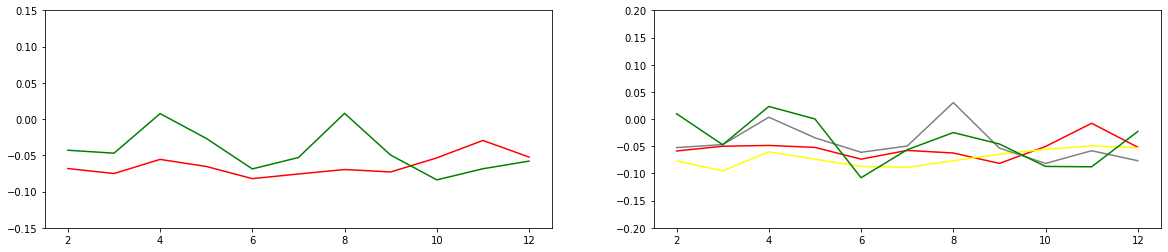

In [171]:
# GET THE GRAPHICS + DELTAS

delta_list_years = {}
delta_extremes_years = {}
list_1 = {}
list_2 = {}
list_3 = {}
list_4 = {}
list_bad = {}
list_good = {}
list_bad_count = {}
list_good_count = {}

for year_cutoff in year_cutoffs:
    data2=data
    #data2=data2[(data2['country_div_1']==True)] #& (data2['country_div_4']==True)] ## DELETE
    data2['odds_max_input_condition'] = data2['Avg2<2.5']<=odds_max_input
    data2['odds_min_input_condition'] = data2['Avg2<2.5']>=odds_min_input
    data2 = data2[(data2['odds_max_input_condition']==True) & (data2['odds_min_input_condition']==True)]
    data_date2 = data2['Date']
    data_date_2 = pd.to_datetime(data_date2, dayfirst = True) 
    data2['test_dates'] = (data_date_2>=year_cutoff[0]) & (data_date_2<year_cutoff[1])
    data2['train_dates'] = (data_date_2>=min_date) & (data_date_2<year_cutoff[0])
     #& (data['1.0_to_1.5']==True)
    
    # Build the train and test datasets
    X_train_0 = data2[data2['train_dates']==True][list_of_features]#,'year_number_ratio','month_number_ratio']]
    X_test_0 = data2[(data2['test_dates']==True)][list_of_features]#,'year_number_ratio','month_number_ratio']]
    y_train_0 = data2[data2['train_dates']==True][payout_cat]-1
    y_test_0 = data2[(data2['test_dates']==True)][payout_cat]-1
    # & (data['1.0_to_1.5']==True)
    
    # Storing year_number variable (to build the dictionaries)
    year_number = X_test_0['year_number'].min()
    
    # null the lists
    results_xgb_true=[] 
    results_xgb_false=[]
    results_xgb_true_count=[] 
    results_xgb_false_count=[]
    results_xgb_1=[]
    results_xgb_2=[]
    results_xgb_3=[]
    results_xgb_4=[]
    
    # reinitate the test_size
    test_size_0=0
    train_size_0=0

    # run the function -- 98% only!! fix
    median_results_bad_bets, median_results_good_bets, median_results_group_1_bets, median_results_group_2_bets, median_results_group_3_bets, median_results_group_4_bets, delta, delta_extremes, median_results_bad_bets_count, median_results_good_bets_count = checking_model_regressor_results(1,0.80,0.80)
    
    # store the results
    delta_list_years[year_number]=delta
    delta_extremes_years[year_number]=delta_extremes
    
    list_1[year_number]=median_results_group_1_bets
    list_2[year_number]=median_results_group_2_bets
    list_3[year_number]=median_results_group_3_bets
    list_4[year_number]=median_results_group_4_bets
    
    list_bad[year_number]=median_results_bad_bets
    list_good[year_number]=median_results_good_bets
    
    list_bad_count[year_number]=median_results_bad_bets_count
    list_good_count[year_number]=median_results_good_bets_count

#Plotting the results of the XGB Year over Year
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
sns.lineplot(list_bad.keys(), list_bad.values(), color='red',ax=ax[0])
sns.lineplot(list_good.keys(), list_good.values(), color='green',ax=ax[0])
    
sns.lineplot(list_1.keys(), list_1.values(), color='red',ax=ax[1])
sns.lineplot(list_2.keys(), list_2.values(), color='yellow',ax=ax[1])
sns.lineplot(list_3.keys(), list_3.values(), color='grey',ax=ax[1])
sns.lineplot(list_4.keys(), list_4.values(), color='green',ax=ax[1])

ax[0].set_ylim(-0.15,+0.15)
ax[1].set_ylim(-0.2,+0.2)

#np.array(list(delta_list_years.values())).mean(), np.array(list(delta_extremes_years.values())).mean()
list_good_values = np.array(list(list_good.values()))
list_good_values_without_na = [x for x in list_good_values if math.isnan(x) == False]
good_bets_across_years_mean = np.array(list_good_values_without_na).mean()

list_bad_values = np.array(list(list_bad.values()))
list_bad_values_without_na = [x for x in list_bad_values if math.isnan(x) == False]
bad_bets_across_years_mean = np.array(list_bad_values_without_na).mean()

list_4_values = np.array(list(list_4.values()))
list_4_values_without_na = [x for x in list_4_values if math.isnan(x) == False]
best_bets_across_years_mean = np.array(list_4_values_without_na).mean()

list_1_values = np.array(list(list_1.values()))
list_1_values_without_na = [x for x in list_1_values if math.isnan(x) == False]
worse_bets_across_years_mean = np.array(list_1_values_without_na).mean()

print('good_bets_avg_across_years:', good_bets_across_years_mean,
      'bad_bets_avg_across_years:', bad_bets_across_years_mean,
      'best_bets_avg_across_years:', best_bets_across_years_mean,
      'worse_bets_avg_across_years:', worse_bets_across_years_mean)
#sns.histplot(results_xgb_false,kde=True,bins=20,color='red',ax=ax[0])

In [164]:
# from sklearn.model_selection import learning_curve
# X_train_0.shape

In [165]:
# m = xgb.XGBRegressor(reg_lamba=1,n_estimators=260,max_depth=10,alpha=0.001, max_bin=1024)
# train_sizes = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 451]

# # Get train scores (R2), train sizes, and validation scores using `learning_curve`
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=m, X=X_train_0, y=y_train_0, train_sizes=train_sizes, cv=5)

In [166]:
# # Take the mean of cross-validated train scores and validation scores
# train_scores_mean = np.mean(X_train_0)
# test_scores_mean = np.mean(y_train_0)
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# plt.plot(train_sizes, test_scores_mean, label = 'Test score')
# plt.ylabel('r2 score', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.legend()

In [167]:
##########

In [168]:
# GET THE SHAP VALUES

delta_list_years = {}
delta_extremes_years = {}

## Declaring TEST and TRAIN dates
#year_cutoffs = ['2010-09-01','2011-09-01','2012-09-01','2013-09-01','2014-09-01','2015-09-01','2016-09-01','2017-09-01','2018-09-01','2019-09-01','2020-09-01','2021-09-01']
year_cutoffs = ['2010-09-01','2011-09-01','2012-09-01','2013-09-01','2014-09-01','2015-09-01']

for year_cutoff in year_cutoffs:
    data['test_dates'] = (data_date_2>=year_cutoff) & (data_date_2<'2022-09-01')
    data['train_dates'] = (data_date_2>='1900-09-01') & (data_date_2<year_cutoff)
    
    X_train_0 = data[data['train_dates']==True][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_avg_bool','Market_consensus','year_number','1.0_to_1.5','1.5_to_2.0','2.0_to_3','3_to_100']]#,'year_number_ratio','month_number_ratio']]
    X_test_0 = data[data['test_dates']==True][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_avg_bool','Market_consensus','year_number','1.0_to_1.5','1.5_to_2.0','2.0_to_3','3_to_100']]#,'year_number_ratio','month_number_ratio']]
    y_train_0 = data[data['train_dates']==True]['payout_avg_under_2.5']-1
    y_test_0 = data[data['test_dates']==True]['payout_avg_under_2.5']-1
    
    # null the lists
    results_xgb_true=[] 
    results_xgb_false=[]
    results_xgb_1=[]
    results_xgb_2=[]
    results_xgb_3=[]
    results_xgb_4=[]
    
    # reinitate the test_size
    test_size_0=0
    train_size_0=0

    # run the function
    delta, delta_extremes = checking_model_regressor_results_shap(10,0.99,0.90)
    
    # SHAP values
    my_model = xgb.XGBRegressor()
    my_model.fit(X_train_0,y_train_0)
    explainer = shap.TreeExplainer(my_model)
    shap_values = explainer.shap_values(X_test_0)
    shap.summary_plot(shap_values, X_test_0)
    
    delta_list_years[year_cutoff]=delta
    delta_extremes_years[year_cutoff]=delta_extremes
    #delta_list_years.append(delta)
    #delta_extremes_years.append(delta_extremes)

ValueError: too many values to unpack (expected 6)

In [ ]:
# PINNACLE

# Reset the indices
#data.reset_index(inplace=True, drop=True)

# Regressor Model variables
X_train_0 = data[data['train_dates']==True][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_avg_bool','Market_consensus','year_number','1.0_to_1.5','1.5_to_2.0','2.0_to_3','3_to_100']]#,'year_number_ratio','month_number_ratio']]
X_test_0 = data[data['test_dates']==True][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_avg_bool','Market_consensus','year_number','1.0_to_1.5','1.5_to_2.0','2.0_to_3','3_to_100']]#,'year_number_ratio','month_number_ratio']]
y_train_0 = data[data['train_dates']==True]['payout_avg_under_2.5']-1
y_test_0 = data[data['test_dates']==True]['payout_avg_under_2.5']-1

# Classifier Model variables
#y_test_0_classifier = data[data['test_dates']==True]['payout_under_2.5_pinacle_closing']!=0
#y_train_0_classifier = data[data['train_dates']==True]['payout_under_2.5_pinacle_closing']!=0

### Run Regression model

In [ ]:
## RUN THE WHOLE CELL #

# We need to run this to null the lists
results_xgb_true=[] 
results_xgb_false=[]
results_xgb_1=[]
results_xgb_2=[]
results_xgb_3=[]
results_xgb_4=[]
    
#We need to run this to reinitate the test_size
test_size_0=0
train_size_0=0

# We need to run the function -> first: # of tests, second: test size (cannot be 1!), third: train size (cannot be 1!)
checking_model_regressor_results(10,0.999,0.999)

In [ ]:
## Checking the SHAP values for the Regression model

my_model = xgb.XGBRegressor()
my_model.fit(X_train_0,y_train_0)
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X_test_0)
shap.summary_plot(shap_values, X_test_0)

In [ ]:
store_graph

### Run Classification model

In [ ]:
## RUN THE WHOLE CELL #

# We need to run this to null the lists
results_False=[]
results_True=[]
    
#We need to run this to reinitate the test_size
test_size_0=0

# We need to run the function -> first argument is the # of tests, second one is the size of test
checking_model_classifier_results(20,0.8)

# Comments regarding results of the tests we ran and Next Steps

In [ ]:
## Comments

# baseline = 0.008297694850435258 (all features)

# delta without Joao features = 0.014419296789770412 => F:-0.029970666611150436 and T:-0.015551369821380024
# --> WE REMOVE JOAO FEATURE

# delta when removing the odds buckets = -0.009317543146000251 => F:-0.022611272813043187 and T:-0.028804787343669917
# --> WE KEEP THE ODDS BUCKETS

# delta when removing the odds buckets = -0.009317543146000251 => F:-0.022611272813043187 and T:-0.028804787343669917
# --> WE KEEP THE ODDS BUCKETS

# delta when removing the countries and divisions = 0.004795286566703704
# --> WE KEEP THE COUNTRIES AND DIVISIONS

# delta when removing the divisions but keeping the countries = 0.008380480363148559 (worsening)
# delta when removing the countries but keeping the divisions = 0.02259680830123266 (best score ever)
# --> WE KEEP THE DIVSIONS AND REMOVE THE COUNTRIES

# delta when removing the 'month_after_July': 0.013657154854343441 DECREASED A LOT! We keep month after July
# year 2020_2021 = 0.012829398919170131 DECREASED A LOT! 
# TIME MATTERS!! We need months, years, time

# New basline: 0.023917075840908224

#'Pin pays better' does not improve the baseline and we remove it

#'Market_consensus' MATTERS we keep it

#VIG matters

# We should remove the P<PC variable
# BEST DELTA: 0.03151890594630853


In [ ]:
# Next steps:

## Time: Further explore how to optimise the features of time (years, months, hours, etc.)
## Odds: Further explore how to optimise the odds buckets (different bins, min-max scaling)
## VIG + Mkt Consensus: Further explore how to optimise VIG + Market consensus

In [ ]:
m.feature_importances

# [SKIP] Other models + stats package we could use [SKIP]

In [ ]:
# Random Forest

In [ ]:
my_model = xgb.XGBRegressor()
my_model.fit(X_train_0,y_train_0) 
        
        #Make and store the predictions XGBoost
       # y_pred_xgb = m.predict(X_test)
       # y_pred_xgb = pd.DataFrame(y_pred_xgb)

In [ ]:
#my_model = RandomForestRegressor(random_state=0).fit(X_step_joao, y)

In [ ]:
y_pred = my_model.predict(X_test_0)

In [ ]:
# SHAP values

In [ ]:
#import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test_0)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test_0)

#- Vertical location shows what feature it is depicting
#- Color shows whether that feature was high or low for that row of the dataset
#- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

In [ ]:
shap.summary_plot(shap_values, X_test_0, plot_type="bar")

# [SKIP] Features selection [SKIP]

In [ ]:
## Feature Selection function (TO BE CREATED)

# iterables = [[feature_1], [feature_2], [feature_3]]

# for t in itertools.product(*iterables):
#     print (t)

# feature_1 = ['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0','3.0_to_99999.0']
# feature_2 = ['country_div_1','country_div_2','country_div_3','country_div_4']
# feature_3 = ['month_after_July']
# feature_4 = ['year_2021_2022']
# feature_5 = ['game_starts_after_4pm']
# feature_6 = ['Market_consensus']
# feature_7 = ['%vig_p_bool']
# feature_8 = ['payout_under_2.5_pinacle_closing']

# list_features = [feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8]

# from itertools import combinations
# sample_list = list_features
# list_combinations = list()
# for n in range(len(sample_list) + 1):
#     list_combinations += list(combinations(sample_list, n))
# print(list_combinations)

# list_combinations

# ls = list(list_combinations)
# flat_ls = [item for sublist in ls for item in sublist]

# a = list(list_combinations[3])

# mylist = list(list_combinations[3])
# [item[0] for item in mylist]

# list_features_array = np.array(list_features)

# list_features_array

# np.multiply(x[0]*list_features_array)

# from itertools import product
# import numpy as np

# n = 2

# x = product([1, 0], repeat=n)
# x = np.reshape(list(x), (-1, n))
# print(x)

# i=1
# #while i < 3:
# feature_selection_1 = x[0]*list_features_array[i]
# i=i=1
# final_feature_selection = feature_selection_1+feature_selection_2